In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets evaluate transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.3 MB/s eta 0:00:00


In [3]:
from transformers import pipeline
classifier1 = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [4]:
classifier2 = pipeline("zero-shot-classification")

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [152]:
data = pd.read_csv('/content/drive/MyDrive/Work/Bornbhukkad/del/csv/fitchai.csv')
data.head()

,Reviews
0,awesome taste
1,nothing
2,ok
3,taste is good
4,Totally tasteless


In [153]:
#cleaning text data
data["cleaned_review"] = data["Reviews"].apply(lambda x: re.sub(r"[^a-zA-Z0-9\s]", "", x).lower())
data.head()

,Reviews,cleaned_review
0,awesome taste,awesome taste
1,nothing,nothing
2,ok,ok
3,taste is good,taste is good
4,Totally tasteless,totally tasteless


In [154]:
#converting cleaned data to list
data_list = []

for i in range(len(data)):
    data_list.append(data.loc[i,"cleaned_review"])

In [173]:
# Define the judging criteria
criteria = [
    "Quality of food",
    "Quantity of food",
    "Location",
    "Delivery Service",
    "Packaging",
    "Health Factor",
    "Presentation",
    "Décor/ambience",
]

In [162]:
#performing zero-shot classification to identify the criterion
result = []

for i in data_list:
  result.append(classifier2(i,candidate_labels=criteria))

category = []
for i in range(len(data)):
  category.append(result[i]['labels'][0])

data['category'] = category

data.head()

,Reviews,cleaned_review,category
0,awesome taste,awesome taste,Quality of food
1,nothing,nothing,Location
2,ok,ok,Presentation
3,taste is good,taste is good,Quality of food
4,Totally tasteless,totally tasteless,Presentation


In [164]:
#performing sentiment analysis
sentiment = []
for i in range(len(data)):
  sentiment.append(classifier1(data.loc[i,'Reviews']))

final_sentiment = []
for i in range(len(sentiment)):
  final_sentiment.append(sentiment[i][0]['label'])

In [165]:
#appending sentiments in dataframe
def sentiment(data, sentiment):
  for i in range(len(data)):
    for j in criteria:
        if(data.loc[i,"category"] == j):
          data.loc[i,j] = sentiment[i]
        else:
          data.loc[i,j] = 'NEUTRAL'

  return data

In [176]:
#calculating total values
def valuecount(criteria, data):
  results = {}
  for criteria in criteria:
    sentiment_counts = data[criteria].value_counts(normalize=True) * 100

    # Store the results in the dictionary
    results[criteria] = {
        "Positive": sentiment_counts.get("POSITIVE", 0),
        "Neutral": sentiment_counts.get("NEUTRAL", 0),
        "Negative": sentiment_counts.get("NEGATIVE", 0),
    }
  return results

In [167]:
#function to plot the sentiments
def plotting(plot_dict,name):
    categories = list(plot_dict.keys())
    sentiments = ['Positive', 'Neutral', 'Negative']
    num_categories = len(categories)
    width = 0.2

    fig, ax = plt.subplots()

    for i, sentiment in enumerate(sentiments):
        x = np.arange(len(categories)) + i * width
        y = [plot_dict[category][sentiment] for category in categories]
        ax.bar(x, y, width, label=sentiment)

    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'Sentiment Analysis for {name}')
    ax.set_xticks(np.arange(len(categories)) + width * (len(sentiments) - 1) / 2)
    ax.set_xticklabels(categories, rotation=45, ha='right')  # Corrected x-axis tick labels
    ax.legend(title='Sentiments')

    plt.tight_layout()

In [170]:
data = sentiment(data, final_sentiment)
data.head()

,Reviews,cleaned_review,category,Quality of food,Quantity of food,Location,Delivery Service,Packaging,Health Factor,Presentation,Décor/ambience
0,awesome taste,awesome taste,Quality of food,POSITIVE,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL
1,nothing,nothing,Location,NEUTRAL,NEUTRAL,NEGATIVE,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL
2,ok,ok,Presentation,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,POSITIVE,NEUTRAL
3,taste is good,taste is good,Quality of food,POSITIVE,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL
4,Totally tasteless,totally tasteless,Presentation,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEGATIVE,NEUTRAL


In [177]:
results = valuecount(criteria, data)

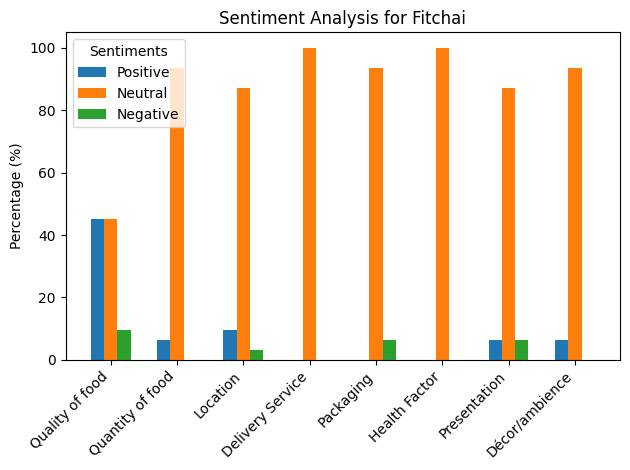

In [178]:
plotting(results,"Fitchai")